
This notebook is for capturing model architecture diagrams. Even though it uses Twitter dataset alone, its the same architecture used for both Twitter and Weibo



In [ ]:
!pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 34.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import re
from os import listdir
import shutil
import glob
import random
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_text as text
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_SAVE_LOCATION = "/content/drive/MyDrive/multimodal-news"
CHECKPOINT_FILEPATH = '/content/drive/MyDrive/multimodal-news/twitter-models/'

## Load the dataframes

In [ ]:
#Load training df
train_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/twitter-train.pickle")
test_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/twitter-test.pickle")
print(train_df_model.shape, test_df_model.shape)

(14258, 3) (1923, 3)


In [ ]:
# This is for Talos as it doesn't take TF DataSet as input
X_train = train_df_model.copy()
y_train = X_train.pop('label')

X_test = test_df_model.copy()
y_test = X_test.pop('label')

# Data input pipeline

In [ ]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


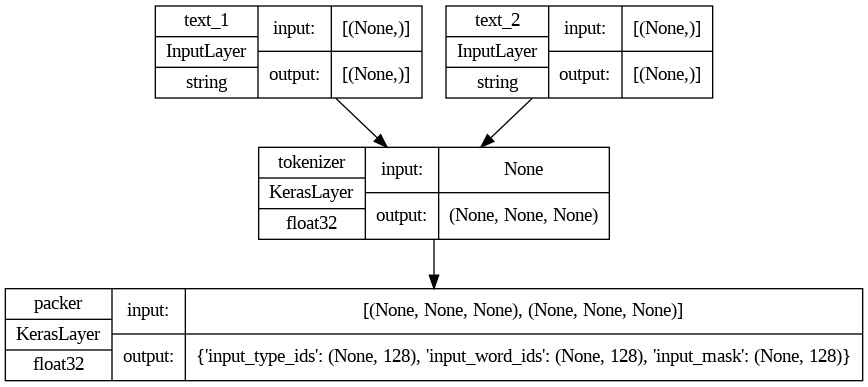

In [ ]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1", "text_2"])
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True, expand_nested=True)

In [ ]:
idx = np.random.choice(len(train_df_model))
row = train_df_model.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model([test_text, test_text])

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: These Marines are protecting the Tomb of Unknown Soldiers during Hurricane Sandy http://t.co/9Zme7cZw
Text 2: These Marines are protecting the Tomb of Unknown Soldiers during Hurricane Sandy http://t.co/9Zme7cZw
Keys           :  ['input_word_ids', 'input_type_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2122 9622 2024 8650 1996 8136 1997 4242 3548 2076 7064 7525 8299
 1024 1013], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [ ]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'image_1', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [ ]:
resize = (224, 224)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [ ]:
def preprocess_image(image_path):
  extension = tf.strings.split(image_path,'.')[-1]
  image = tf.io.read_file(image_path)
  if extension == b"gif":
    image = tf.io.decode_image(image, 3, expand_animations=False)
  elif extension == b"png":
    image = tf.image.decode_png(image, 3)
  else:
    image = tf.image.decode_jpeg(image, 3)
  image = tf.image.resize(image, resize)
  return image

In [ ]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1, text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [ ]:
def preprocess_text_and_image(sample):
  image_1 = preprocess_image(sample["image_1"])
  text = preprocess_text(sample["tweetText"])
  return {"image_1": image_1, "text": text}

In [ ]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [ ]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [ ]:
train_ds = prepare_dataset(train_df_model)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

### Projection

In [ ]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


### Vision encoder

In [ ]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.EfficientNetV2B3(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    
    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed_1)
    #embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1], outputs, name="vision_encoder")

### Text Encoder

In [ ]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

### Multi Head Attention Layer

In [ ]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="relu"), keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, x, y, training):
        attn_output = self.att(x, y)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Text-Only model Architecture

In [ ]:
def create_text_only_model (
    num_projection_layers=0,
    projection_dims=224,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
    attention=False
    ):
  
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)
    outputs = text_projections
    return keras.Model([text_inputs], outputs)


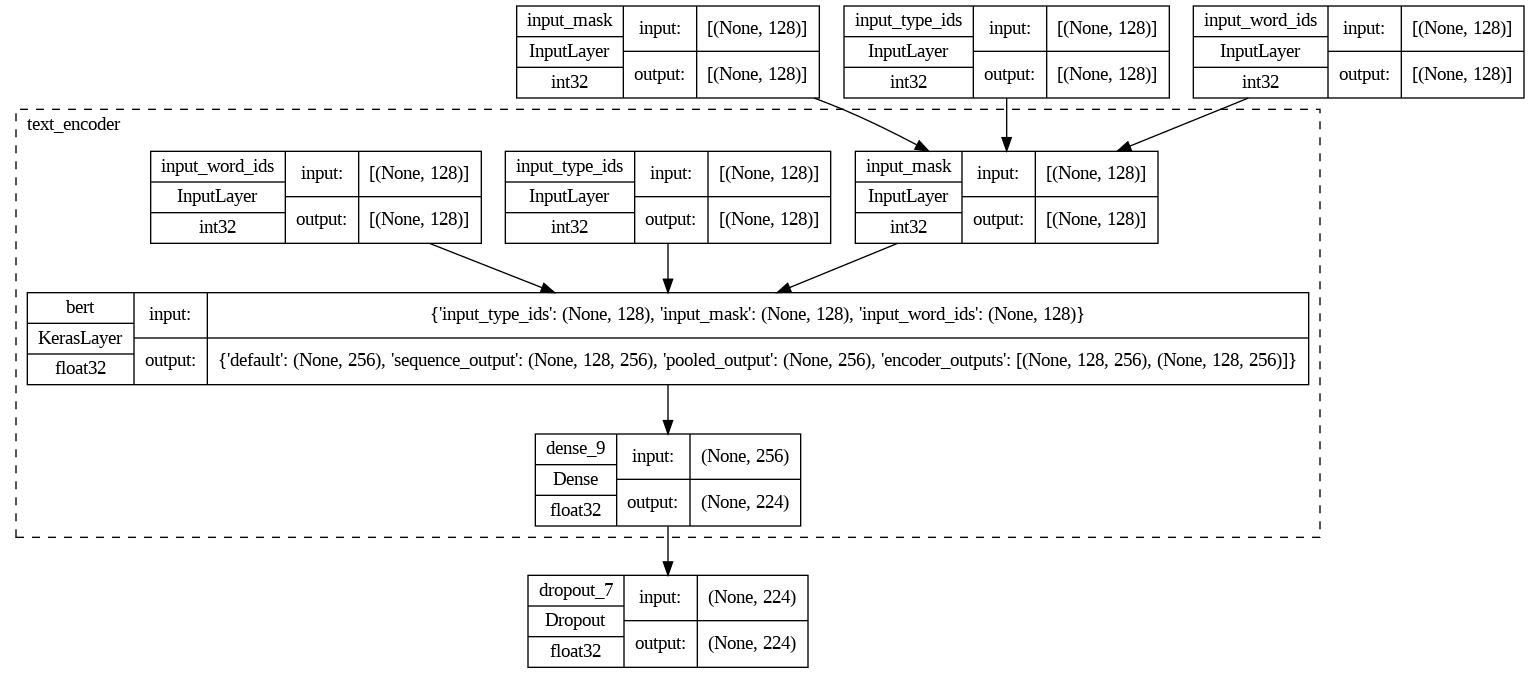

In [ ]:
text_only_model = create_text_only_model()
keras.utils.plot_model(text_only_model, show_shapes=True, show_dtype=True, expand_nested=True)

## Vision-only model architecture

In [ ]:
def create_vision_only_model (
    num_projection_layers=0,
    projection_dims=224,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
    attention=False
    ):
  
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    vision_projections = vision_encoder([image_1])
    vision_projections = keras.layers.Dropout(dropout_rate)(vision_projections)
    outputs = vision_projections
    return keras.Model([image_1], outputs)

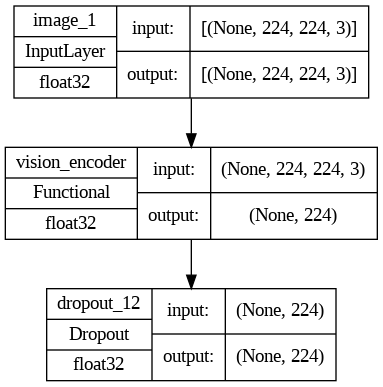

In [ ]:
vision_only_model = create_vision_only_model()
keras.utils.plot_model(vision_only_model, show_shapes=True, show_dtype=True)

## MultiModal model

In [ ]:
def create_multimodal_model(
    num_projection_layers=0,
    projection_dims=224,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
    attention=False
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(224, 224, 3), name="image_1")
    
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1])
    vision_projections = keras.layers.Dropout(dropout_rate)(vision_projections)
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)
    
    # Cross-attention.
    if attention:
      transformer_block = TransformerBlock(projection_dims, 4, projection_dims)
      x = transformer_block(tf.expand_dims(vision_projections, -1), tf.expand_dims(text_projections, -1))
      x = tf.keras.layers.Flatten()(x)
      x = project_embeddings(
        x, 1, projection_dims, dropout_rate) 
      query_value_attention_seq = keras.layers.Attention(use_scale=True, dropout=0.2)(
            [vision_projections, text_projections]
        )
      
    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    if attention:
        concatenated = keras.layers.Concatenate()([concatenated, x, query_value_attention_seq])
        #x = tf.keras.layers.Flatten(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(concatenated)
    return keras.Model([image_1, text_inputs], outputs)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

## Final Multimodal model

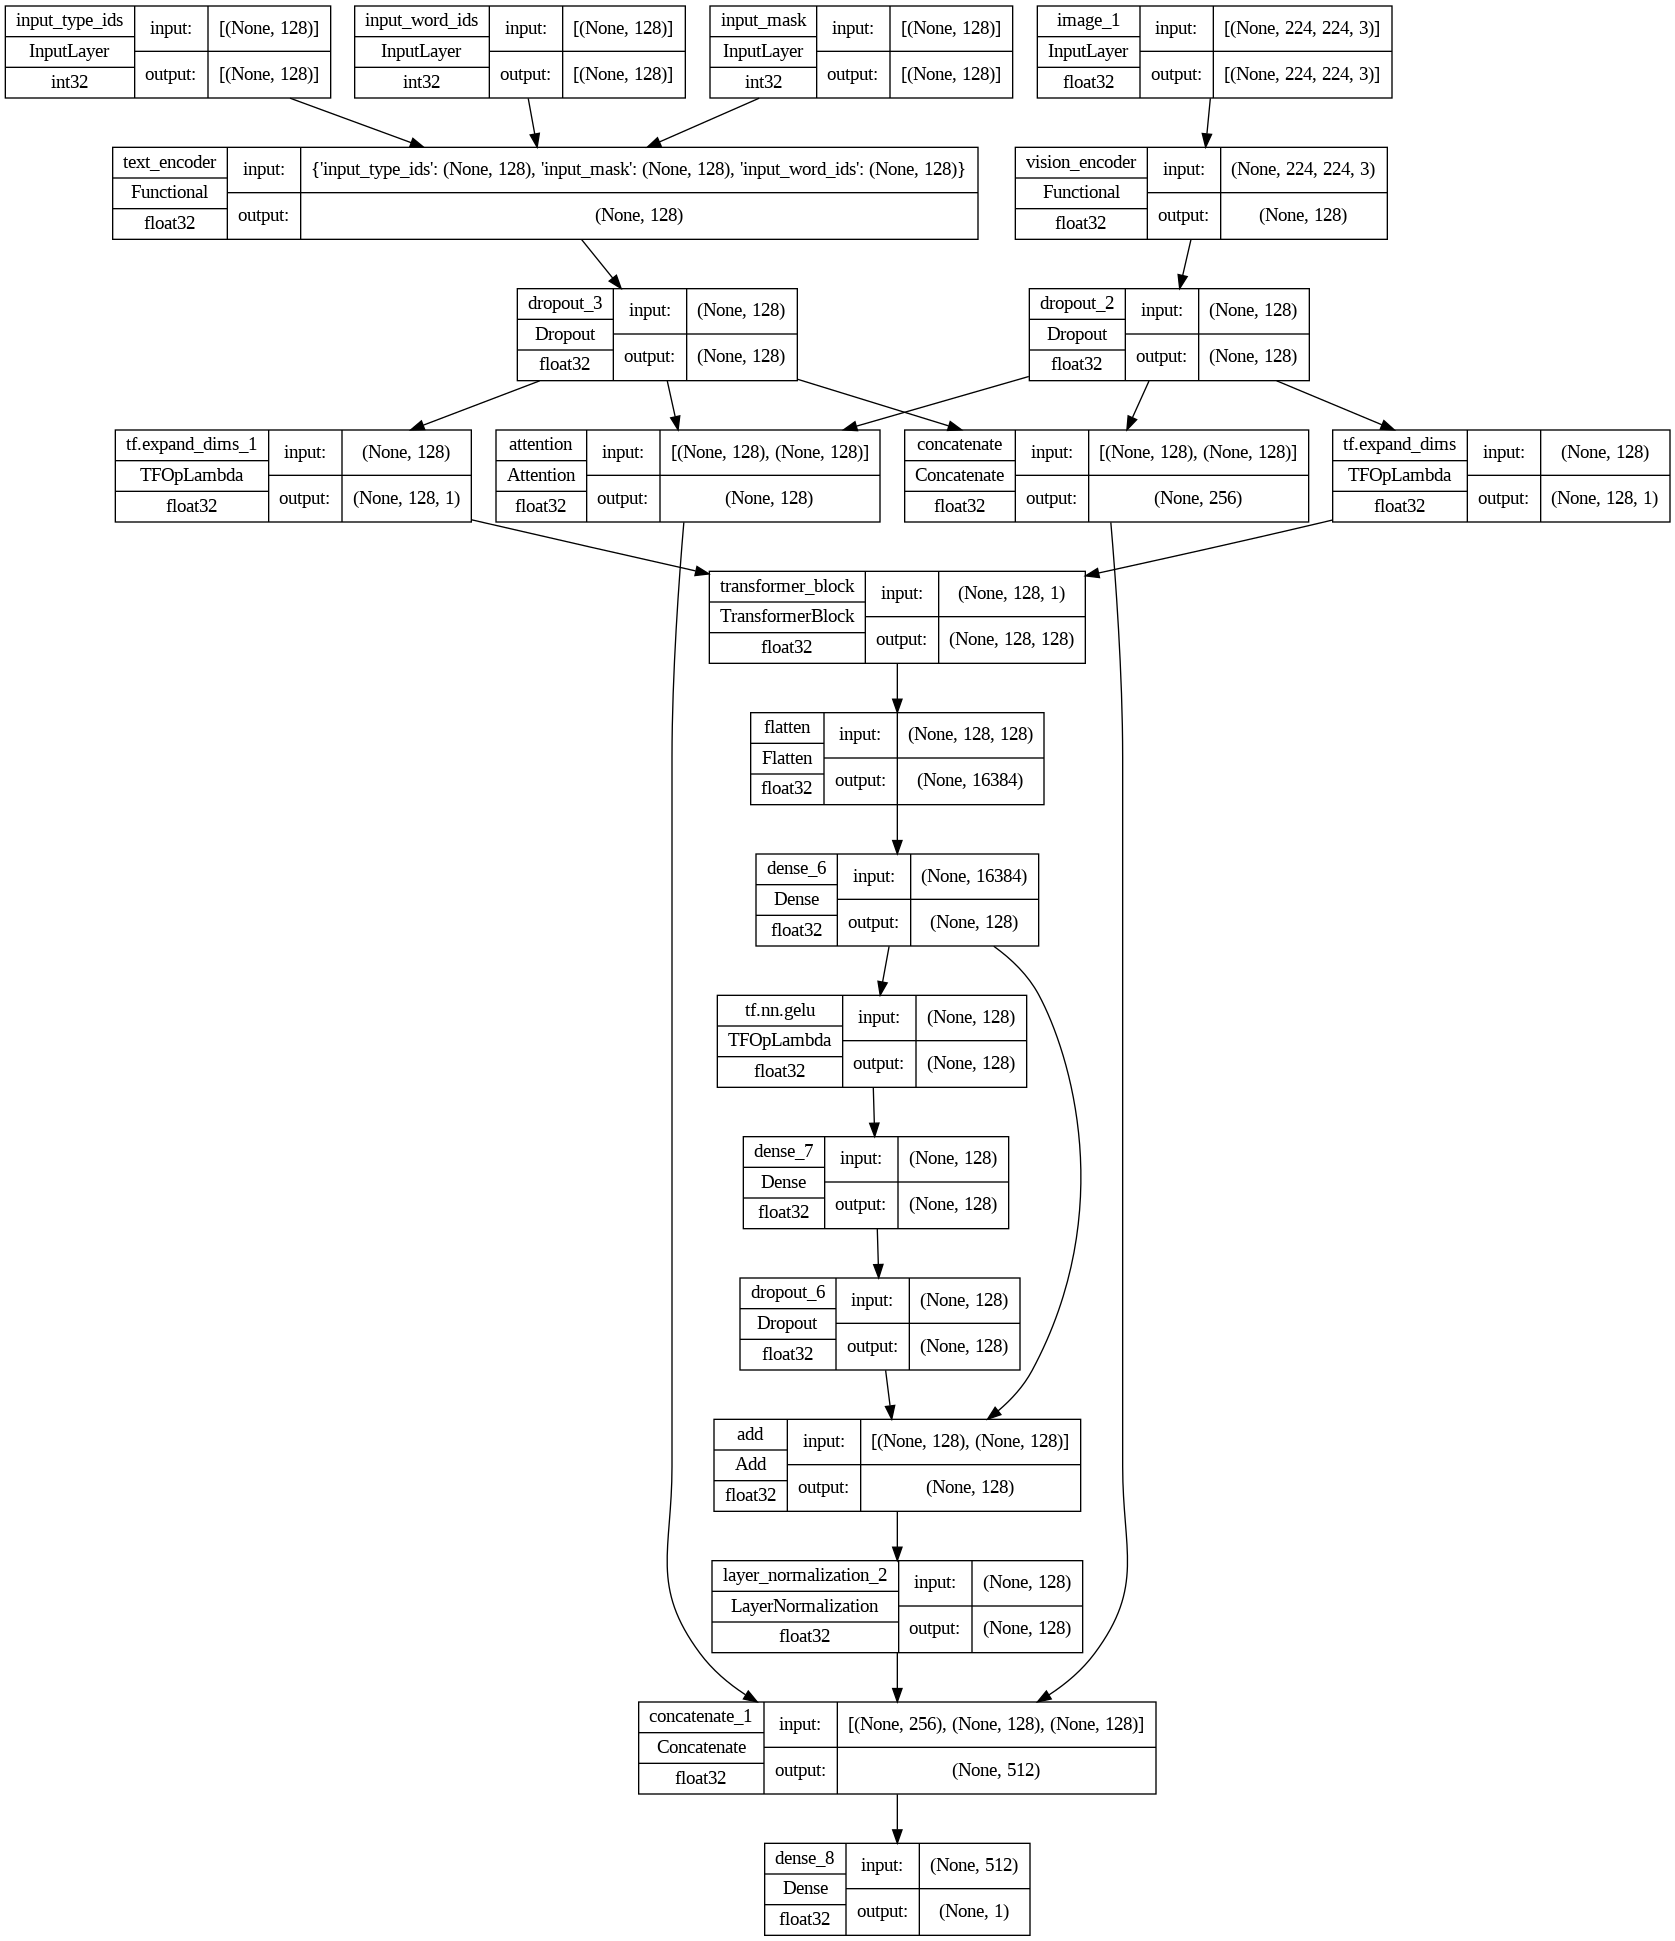

In [ ]:
multimodal_model = create_multimodal_model(attention=True, num_projection_layers=0, projection_dims=128, dropout_rate=0.2)
keras.utils.plot_model(multimodal_model, show_shapes=True, show_dtype=True)